# Introducción

El proyecto consiste en el estudio del compartamiento de usuario de una empresa emergente que vende productos alimenticios, para ello realizará un estudio de embudo de ventas y se analizará los resultados de test A/A/B que ayudará en la decisión de cambiar las fuentes de la aplicación. En este caso se cuenta con dos grupos de control (A) y grupo de prueba (B)

# Paso 1 Carga de data

In [128]:
# importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math

In [11]:
# carga de data
data = pd.read_csv("logs_exp_us.csv")

# Paso 2. Preparar los datos para el análisis

## Cambiando nombres de columnas

In [12]:

#separar columnas
data[['event_name', 'device_id_hash', 'event_times_tamp', 'exp_id']] = data["EventName\tDeviceIDHash\tEventTimestamp\tExpId"].str.split("\t", expand=True)
# eliminar la columna original
data.drop(
    columns=["EventName\tDeviceIDHash\tEventTimestamp\tExpId"], inplace=True)

In [13]:
data.head()

,event_name,device_id_hash,event_times_tamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Comprobando  tipos de datos y valores ausentes.

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             243713 non-null  int64         
 1   event_name        243713 non-null  category      
 2   device_id_hash    243713 non-null  object        
 3   event_times_tamp  243713 non-null  object        
 4   exp_id            243713 non-null  int32         
 5   fecha_hora        243713 non-null  datetime64[ns]
 6   fecha             243713 non-null  object        
dtypes: category(1), datetime64[ns](1), int32(1), int64(1), object(3)
memory usage: 10.5+ MB


No hay valores ausentes

In [15]:
data["event_name"] = data["event_name"].astype('category') # convirtiendo a columna categorica

In [16]:
data["exp_id"] = data["exp_id"].astype('int') # convirtiendo a columna int

Verificando duplicados

In [17]:
data.duplicated().sum()

413

In [18]:
print(data[data.duplicated()])

                     event_name       device_id_hash event_times_tamp  exp_id
453            MainScreenAppear  5613408041324010552       1564474784     248
2350           CartScreenAppear  1694940645335807244       1564609899     248
3573           MainScreenAppear   434103746454591587       1564628377     248
4076           MainScreenAppear  3761373764179762633       1564631266     247
4803           MainScreenAppear  2835328739789306622       1564634641     248
...                         ...                  ...              ...     ...
242329         MainScreenAppear  8870358373313968633       1565206004     247
242332  PaymentScreenSuccessful  4718002964983105693       1565206005     247
242360  PaymentScreenSuccessful  2382591782303281935       1565206049     246
242362         CartScreenAppear  2382591782303281935       1565206049     246
242635         MainScreenAppear  4097782667445790512       1565206618     246

[413 rows x 4 columns]


In [19]:
#borrando duplicados
data=data.drop_duplicates().reset_index()

## Agregando columna de fecha y hora y una columna separada para las fechas

In [20]:
data["fecha_hora"] = pd.to_datetime(data["event_times_tamp"], unit='s')# convirtiendo a datatime

C:\Users\LUCIA\AppData\Local\Temp\ipykernel_9248\1114602985.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data["fecha_hora"] = pd.to_datetime(data["event_times_tamp"], unit='s')# convirtiendo a datatime


In [21]:
data["fecha"]=data["fecha_hora"].dt.date #extrayendo fecha

In [22]:
data.head()

,index,event_name,device_id_hash,event_times_tamp,exp_id,fecha_hora,fecha
0,0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:44,2019-07-25
1,1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:12:00,2019-07-25
2,2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:29:04,2019-07-25
3,3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:29:04,2019-07-25
4,4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:16,2019-07-25


# Paso 3. Estudiar y comprobar los datos

## ¿Cuántos eventos hay en los registros?

In [23]:
data["event_name"].unique()  # revisando valores únicos

['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']
Categories (5, object): ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

Hay 5 eventos en los registros.

## ¿Cuántos usuarios y usuarias hay en los registros?

In [24]:
data["device_id_hash"].nunique()  # revisando valores únicos

7551

Hay 7551 usuarios en el registro

## ¿Cuál es el promedio de eventos por usuario?

In [25]:
neventos_usuario=data.groupby("device_id_hash")["event_name"].count()
neventos_usuario.mean()

32.27559263673685

El promedio de eventos por usuario es 32.26, sugiere que un mismo realizo los eventos repetidas veces, posiblemente en distintas fechas.

## ¿Qué periodo de tiempo cubren los datos? . 

In [26]:
print(data["fecha"].min())
print(data["fecha"].max())

2019-07-25
2019-08-07


Los datos cubren desde 25-07-2019 hasta el 07-08-2019

Histograma por fecha y hora.

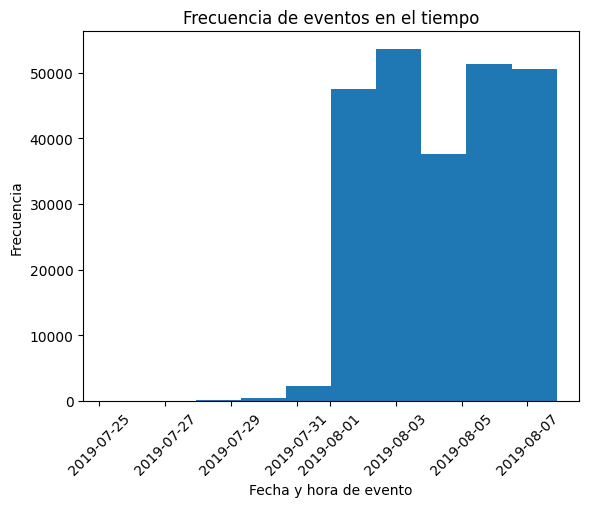

In [27]:
plt.hist(data["fecha_hora"])

# Agregar etiquetas y título
plt.xlabel('Fecha y hora de evento')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de eventos en el tiempo')
plt.xticks(rotation=45)

plt.show()

La mayoría de los datos se encuentran entre 31-07-2019 y 07-08-2019

## ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? 

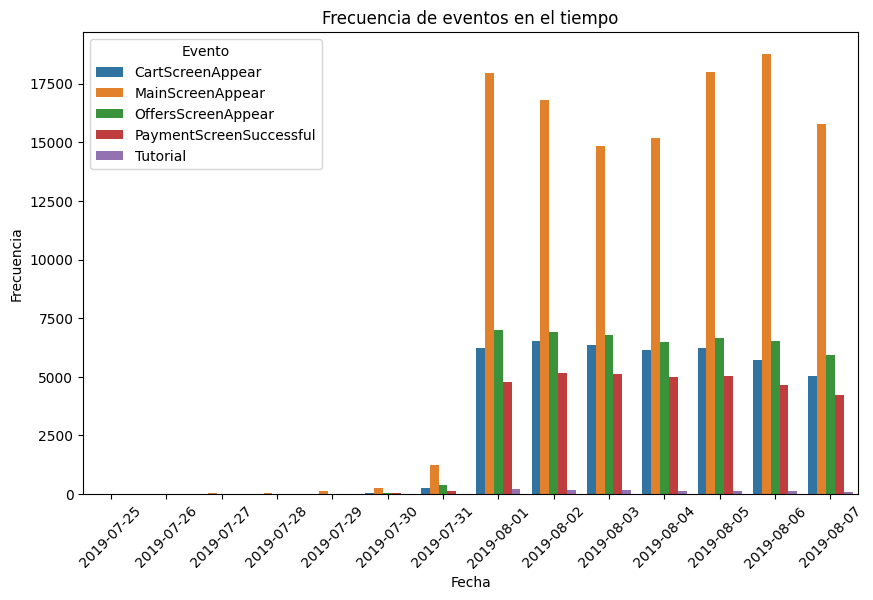

In [39]:
# Configuración del gráfico
plt.figure(figsize=(10, 6))

# Graficar el countplot con el parámetro hue
sns.countplot(x='fecha', hue='event_name', data=data)

# Agregar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de eventos en el tiempo')

# Rotar las etiquetas del eje X para mejorar la legibilidad
plt.xticks(rotation=45)

plt.legend(title='Evento')  # Agregar leyenda

plt.show()

En el gráfico se puede observar que se tiene una data más completa a partir del 01/08/2019 hasta el 07/08/2019, se observa tambien que cada día contiene los 5 eventos. Así que será el periodo elegido para el análisis.

## ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [50]:
data['fecha'] = pd.to_datetime(data['fecha'], format="%Y/%m/%d")
fecha_inicial = pd.to_datetime("2019-08-01")
data_filtrada = data[data["fecha"]>= fecha_inicial]

In [56]:
var_eventos = (1 - len (data_filtrada)/len(data))*100
var_usuarios = (1 - data_filtrada["device_id_hash"].nunique()/data["device_id_hash"].nunique())*100

In [57]:
print(var_eventos)
print(var_usuarios)

1.1591503120473634
0.22513574361011646


Se eliminó el 1.15 % de usuarios y 0.22% de eventos con respecto a la data inicial.

## Grupos de usuarios experimentales

In [59]:
data_filtrada.groupby("exp_id")["device_id_hash"].nunique() #cantidad de usuarios por grupo experimental

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Se observa que hay similar cantidad de usuarios en cada grupo experimental

# Paso 4. Estudiar el embudo de eventos

## Frecuencia de eventos

In [71]:
data_filtrada.groupby("event_name")["exp_id"].count().sort_values(ascending= False).reset_index()

C:\Users\LUCIA\AppData\Local\Temp\ipykernel_9248\1910978074.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_filtrada.groupby("event_name")["exp_id"].count().sort_values(ascending= False).reset_index()


,event_name,exp_id
0,MainScreenAppear,117329
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


## Cantidad de usuarios por evento

In [77]:
data_eventos=data_filtrada.groupby("event_name")["device_id_hash"].nunique().sort_values(ascending=False).reset_index()
display(data_eventos)

C:\Users\LUCIA\AppData\Local\Temp\ipykernel_9248\2420504992.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_eventos=data_filtrada.groupby("event_name")["device_id_hash"].nunique().sort_values(ascending=False).reset_index()


,event_name,device_id_hash
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


## Orden de acciones

En el orden que se  muestra :


MainScreenAppear           
OffersScreenAppear         
CartScreenAppear           
PaymentScreenSuccessful    
Tutorial 

In [81]:
# Calculando embudo
data_eventos["n_id_prev"] = data_eventos["device_id_hash"].shift(1)


In [85]:
data_eventos["variación"] = data_eventos["device_id_hash"] / data_eventos["n_id_prev"]  

In [96]:
data_eventos["conversion"] = data_eventos["device_id_hash"] / \
    data_eventos["n_id_prev"]
data_eventos["ratio"] = 1- data_eventos["conversion"]


In [98]:
display(data_eventos)

,event_name,device_id_hash,nid_prev,n_id_prev,variación,ratio,conversion
0,MainScreenAppear,7419,NaN,NaN,NaN,NaN,NaN
1,OffersScreenAppear,4593,7419.0,7419.0,0.619086,0.380914,0.619086
2,CartScreenAppear,3734,4593.0,4593.0,0.812976,0.187024,0.812976
3,PaymentScreenSuccessful,3539,3734.0,3734.0,0.947777,0.052223,0.947777
4,Tutorial,840,3539.0,3539.0,0.237355,0.762645,0.237355


In [92]:
conversión_total = 840/7419*100
print(conversión_total)

11.322280630812779


In [101]:
conversión_pago = 3539/7419*100
print(conversión_pago)

47.70184661005526


La etapa en la que se pierde más usuarios al pasar del primer evento al segundo evento se pierde 2697 usuarios.
El 11.32% de usuarios llegan al evento final. El 47.7% de los usuarios pasan del primer evento hasta realizar el pago.

# Paso 5. Estudiar los resultados del experimento

¿Cuántos usuarios y usuarias hay en cada grupo?

In [102]:
data_filtrada.groupby("exp_id")["device_id_hash"].nunique()  # cantidad de usuarios por grupo experimental

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

##  Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [103]:
data_filtrada.head()

,index,event_name,device_id_hash,event_times_tamp,exp_id,fecha_hora,fecha
2825,2827,MainScreenAppear,2413191300976302222,1564617599,247,2019-08-01 00:00:00,2019-08-01
2826,2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:06:24,2019-08-01
2827,2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:32,2019-08-01
2828,2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:32,2019-08-01
2829,2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:32,2019-08-01


In [115]:
#función prueba de significancia para dos grupos

def t_test(df, group1, group2, event, group_col="exp_id"):

    conversions = df[["device_id_hash", group_col]].drop_duplicates()

    converted = pd.DataFrame(data={
        "device_id_hash": df[df["event_name"] == event]["device_id_hash"].unique(),
        "converted": 1
    })

    conversions = conversions.merge(converted, on="device_id_hash", how="left")
    conversions["converted"] = conversions["converted"].fillna(0)

    statistic, pvalue = ttest_ind(
        conversions[conversions[group_col] == group1]["converted"],
        conversions[conversions[group_col] == group2]["converted"]
    )

    return statistic, pvalue

In [125]:
events = data_filtrada["event_name"].unique()
print("Running A/A tests...")
for event in events:
    _, pvalue = t_test(data_filtrada, 246, 247, event)

    print(f"""
  Event: {event}
  p-value: {pvalue}
  """)
    print()

Running A/A tests...

  Event: MainScreenAppear
  p-value: 0.7571174621103072
  


  Event: Tutorial
  p-value: 0.9377151544645461
  


  Event: OffersScreenAppear
  p-value: 0.24818223444867904
  


  Event: CartScreenAppear
  p-value: 0.22891646330485427
  


  Event: PaymentScreenSuccessful
  p-value: 0.1146123316324848
  



In [131]:
n_pruebas = 4
alpha = 0.05

print(f"""
Nivel de significancia para cada prueba debe ser mayor a : {1 - math.pow((1 - alpha), 1/n_pruebas)}
""")


Nivel de significancia para cada prueba debe ser mayor a : 0.012741455098566168



No se puede rechazar la hipotesis nula, lo que podemos concluir que no hay una diferencia estadísticamente significativa entre las muestras

In [134]:
data_filtrada.loc[data_filtrada["exp_id"].isin([246, 247]), "prueba_a_b"] = "A"
data_filtrada.loc[data_filtrada["exp_id"].isin([248]), "prueba_a_b"] = "B"

In [137]:
events = data_filtrada["event_name"].unique()
controls = [246, 247]

print("Running A/B tests...")
print()
for event in events:

    print(f"Event: {event}")

    for control in controls:

        _, pvalue = t_test(data_filtrada, control,248, event)

        print(f"""
    Comparison: {control} vs. experiment
    p-value: {pvalue}
    """)
    _, pvalue = t_test(data_filtrada, "A", "B", event, group_col="prueba_a_b")

    print(f"""
  Comparison: all control vs. experiment
  p-value: {pvalue}
  """)

Running A/B tests...

Event: MainScreenAppear

    Comparison: 246 vs. experiment
    p-value: 0.29506606465679136
    

    Comparison: 247 vs. experiment
    p-value: 0.45880437959723175
    



  Comparison: all control vs. experiment
  p-value: 0.294307760265927
  
Event: Tutorial

    Comparison: 246 vs. experiment
    p-value: 0.8264715202653616
    

    Comparison: 247 vs. experiment
    p-value: 0.7653793082832738
    

  Comparison: all control vs. experiment
  p-value: 0.7648996614965458
  
Event: OffersScreenAppear

    Comparison: 246 vs. experiment
    p-value: 0.20843948636199391
    

    Comparison: 247 vs. experiment
    p-value: 0.9198015341631126
    

  Comparison: all control vs. experiment
  p-value: 0.43432243008491267
  
Event: CartScreenAppear

    Comparison: 246 vs. experiment
    p-value: 0.07845751752267907
    

    Comparison: 247 vs. experiment
    p-value: 0.5787080147829399
    

  Comparison: all control vs. experiment
  p-value: 0.18180539347221458
  
Event: PaymentScreenSuccessful

    Comparison: 246 vs. experiment
    p-value: 0.2123337471133262
    

    Comparison: 247 vs. experiment
    p-value: 0.7374027184332623
    

  Comparison: a

In [138]:
n_pruebas = 12
alpha = 0.05

print(f"""
Nivel de significancia para cada prueba debe ser mayor a : {1 - math.pow((1 - alpha), 1/n_pruebas)}
""")


Nivel de significancia para cada prueba debe ser mayor a : 0.004265318777560645



No se puede rechazar la hipotesis nula, lo que podemos concluir que no hay una diferencia estadísticamente significativa entre las muestras

# Conclusiones

En este caso, no hay evidencia suficiente para rechazar la hipótesis nula de que no hay diferencia entre los grupos A y B. Por lo tanto, se concluye que los grupos A y B son similares y que cualquier diferencia observada entre ellos podría deberse al azar en lugar de a un efecto real.

Cambiar las fuentes de toda la aplicación no genera cambios significativos en el comportamiento del usuario.

Solo el 61% de usuarios ven la pantalla de ofertas, luego de ver la pantalla de inicio.Esto puede sugerir indagar cuál es el motivo que hace que sea la etapa donde se pierda la mayor cantidad de usuarios. Quizá la pantalla de ofertas tarda en aparecer o no se está mostrando como deberia.